# INFO 3350/6350

## Lecture 15: Training and Fine-Tuning BERT for Classification

## Classfying Goodreads Reviews By Book Genre

> Adapted from original work by Maria Antoniak, Melanie Walsh, and the [AI for Humanists](https://www.aiforhumanists.com/people//) Team

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on Goodreads reviews from the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews?authuser=0) with the goal of predicting the genre of the book being reviewed. The genres include:
- poetry
- comics & graphic
- fantasy & paranormal
- history & biography
- mystery, thriller, & crime
- romance
- young adult  

**Basic steps involved in using BERT and HuggingFace:**
1. Divide your data into training and test sets.
2. Encode your data into a format BERT will understand.
3. Combine your data and labels into datset objects.
4. Load the pre-trained BERT model.
5. Fine-tune the model using your training data.
6. Predict new labels and evaluate performance on your test data.



## Imports

**NB.** This notebook is intended to be run on Google Colab. You can also run it locally with minimal modifications, such as replacing `gdown` with the location of local files. If you do run locally, you'll probably want to have a decent GPU.

In [36]:
# Basic Python modules
from collections import defaultdict
import random
import pickle

# For working with gzip files
# https://docs.python.org/3/library/gzip.html
import gzip

# For working with JSON files
import json

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch

# For plotting and data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

# imports from transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments


## Set parameters and file paths

In [2]:
# This is the name of the BERT model that we want to use.
# We're using DistilBERT to save space (it's a distilled version of the full BERT model),
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'
device_name = 'cuda' # or 'cpu' or 'mps' or 'cuda', etc .

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'distilbert-reviews-genres'

# Download the reviews data (can be slow; uses gdown, so only runs on colab) or load from disk?
download_data = False

## Load and sample Goodreads data

Create a Python dictionary with each genre and the link to the corresponding UCSD Goodreads review data for that genre on Google Drive.

*If you manually click on any of the URLs, you will be able to download the data for that genre. For example, here's the link for poetry: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO*

In [3]:
# This is where our target data is hosted on the web. You only need these paths for the book review dataset.

# Source: https://mengtingwan.github.io/data/goodreads.html#datasets

genre_url_dict = {'poetry':                 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_poetry.json.gz',
                  'children':               'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_children.json.gz',
                  'comics_graphic':         'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_comics_graphic.json.gz',
                  'fantasy_paranormal':     'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_fantasy_paranormal.json.gz',
                  'history_biography':      'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_history_biography.json.gz',
                  'mystery_thriller_crime': 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_mystery_thriller_crime.json.gz',
                  'romance':                'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_romance.json.gz',
                  'young_adult':            'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_young_adult.json.gz'}

If we set `download_data = True`, loop over the dictionary and use `gdown` to download the Goodreads review data for each genre from the open web. Else, load from local storage (already downloaded).

In [4]:
if download_data:
    # For downloading large files from Google Drive
    # https://github.com/wkentaro/gdown
    import gdown

    for _genre, _url in genre_url_dict.items():
      gdown.download(_url, _genre + '.json.gz', quiet=False)

If you click the file browser icon in the left-hand side bar, you should see that these files have now been download.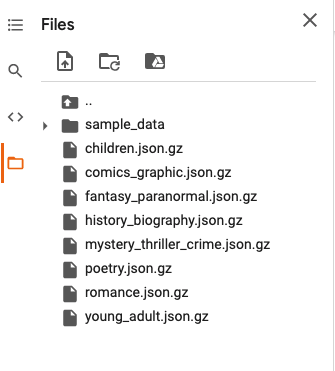

Next we create a function `load_reviews()`, which will use `gzip` to unzip the downloaded Goodreads review JSON files and `json` to load the JSON files once they're unzipped.

In [5]:
if download_data:
    def load_reviews(file_name,
                     head=None):

        reviews = []
        count = 0

        with gzip.open(file_name) as file:
            for line in file:

                d = json.loads(line)
                count += 1

                _book_id = d['book_id']

                reviews.append(d['review_text'])

                # Break if we reach the Nth line
                if (head is not None) and (count > head):
                    break

        return reviews

Now we apply the `load_reviews()` function. For each genre, we load and unzip the corresponding `.json.gz` file, e.g., `poetry.json.gz`, then we randomly sample 2000 Goodreads reviews and make a dictionary `genre_reviews_dict` of all these reviews.

In [6]:
if download_data:
    genres = ['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult']
    genre_reviews_dict = {}

    for _genre in genres:
      print('Loading ' + _genre + '.json.gz')

      _reviews = load_reviews(_genre + '.json.gz')
      genre_reviews_dict[_genre] = random.sample(_reviews, 2000)

    # write our sampled data
    pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
else:
    genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

Let's preview a couple of the key-value pairs in `genre_reviews_dict`

In [7]:
 for _genre, _reviews in genre_reviews_dict.items():
    print(_genre)
    print(random.sample(_reviews, 1)[0])

poetry
3.5 neat artwork
children
Who doesn't love Pooh? 
 I always loved watching Pooh on Saturdays it was a great treat for me yes I know that was the Disney version) I also would read it with my mom and we would make different voices for all the characters. I know what I grew up with was a little different from the books (art wise) but all and all I still have fond memories of Pooh and gang.
comics_graphic
Another must read graphic novel! One would think that being the last man on the planet, surrounded by women would be a good thing...turns out it's not. 
 Meet Yorick, an escape artist, college student, and aspiring showman. Life is good for him. His sister is a paramedic, his mom is a senator, and his beautiful girlfriend is about to become his fiancee. What could go wrong? 
 In one moment every living thing with a Y chromosome dies. Every single male human or animal erupts in spasms and spews blood and then dies...except for Yorick and his per monkey Ampersand. Unsure of what has 

## Split the data into training and test sets

We'll use a standard 80/20 train/test split. Note that we sample 1,000 of the 2,000 reviews per genre that we selected for each sample. Trying to keep things small enough to run in reasonable time on limited hardware.

**Note:** Normally, to tune the hyperparameters, you should also create a "validation" set for tuning, and only use the "test" set once, at the end of all tuning. For simplicity, in this tutorial, we will only using a training and test set.

In [8]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

  _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.

  for _review in _reviews[:800]:
    train_texts.append(_review)
    train_labels.append(_genre)
  for _review in _reviews[800:]:
    test_texts.append(_review)
    test_labels.append(_genre)

Show how many Goodreads reviews and labels we have in each category: 6400 training reviews, 6400 training labels (genres), 1600 test reviews, 1600 test labels (genre)

In [9]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(6400, 6400, 1600, 1600)

Here's an example of a training label and review:

In [10]:
train_labels[1], train_texts[1]

('poetry',
 'Desde la primera ocasion que lei a Huerta, encontre mucha fuerza en sus lineas; tal vez eso sea lo que termina por enganchar a sus seguidores. Libro ideal para quien quiera acercarse por vez primera a la obra de Efrain Huerta, incluso, para quienes desean vagar por segunda vez entre sus mejores poemas. El libro guarda bien la esencia del escritor.')

## Run a baseline model (logistic regression)

It's important to know performance we can expect on a given task using a system that we already understand well. Here, we train and evaluate a simple TF-IDF baseline model using logistic regression.

We find better-than-random performance, even for a very small dataset. We'll see whether BERT can beat this good baseline.

In [11]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [12]:
clf = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = clf.predict(X_test)

We can use scikit-learn's `classification_report` function to evaluate how well the logistic regression model's predictions match up with the true labels for the Goodreads reviews.

Importantly, we can see that our average scores are above random performance (we have 8 classes, so random performance would be ~0.2).

In [13]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.56      0.56      0.56       200
        comics_graphic       0.54      0.59      0.57       200
    fantasy_paranormal       0.33      0.28      0.30       200
     history_biography       0.51      0.48      0.50       200
mystery_thriller_crime       0.54      0.46      0.49       200
                poetry       0.60      0.73      0.66       200
               romance       0.42      0.45      0.43       200
           young_adult       0.35      0.35      0.35       200

              accuracy                           0.49      1600
             macro avg       0.48      0.49      0.48      1600
          weighted avg       0.48      0.49      0.48      1600



## Encode data for BERT

We're going to transform our texts and labels into a format that BERT (via Huggingface and PyTorch) will understand. This is called *encoding* the data.

Here are the steps we need to follow:

1. The labels&mdash;in this case, Goodreads genres&mdash;need to be turned into integers rather than strings.

2. The texts&mdash;in this case, Goodreads reviews&mdash;need to be truncated if they're more than 512 tokens or padded if they're fewer than 512 tokens. The tokens, or words in the texts, also need to be separated into "word pieces" and matched to their embedding vectors.

3. We need to add special tokens to help BERT:

| BERT special token | Explanation |
| --------------| ---------|
| [CLS] | Start token of every document. |
| [SEP] | Separator between each sentence |
| [PAD] | Padding at the end of the document as many times as necessary, up to 512 tokens |
|  &#35;&#35; | Start of a "word piece" |




Here we will load `DistilBertTokenizerFast` from the HuggingFace library, which will do all the work of encoding the texts for us. The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Here we will create a map of our labels, or Goodreads genres, to integer keys. We take the unique labels, and then we make a dictionary that associates each label/tag with an integer.

**Note:** HuggingFace documentation sometimes refers to "labels" as "tags" but these are the same thing. We use "labels" throughout this notebook for clarity.

In [15]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [16]:
label2id.keys()

dict_keys(['fantasy_paranormal', 'romance', 'children', 'poetry', 'comics_graphic', 'young_adult', 'mystery_thriller_crime', 'history_biography'])

In [17]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

Now let's encode our texts and labels!

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [19]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

**Examine a Goodreads review in the training set after encoding**

In [20]:
' '.join(train_encodings[1].tokens[0:100])

'[CLS] Des ##de la prime ##ra o ##cas ##ion que le ##i a Hu ##ert ##a , en ##con ##tre much ##a f ##uer ##za en su ##s line ##as ; ta ##l ve ##z es ##o sea lo que term ##ina p ##or en ##gan ##cha ##r a su ##s se ##gu ##ido ##res . Li ##bro ideal para q ##ui ##en q ##ui ##era ace ##rca ##rse p ##or ve ##z prime ##ra a la o ##bra de E ##fra ##in Hu ##ert ##a , in ##c ##lus ##o , para q ##ui ##ene ##s des ##ean v'

**Examine a Goodreads review in the test set after encoding**

In [21]:
' '.join(test_encodings[1].tokens[0:100])

"[CLS] It almost took me a year but I finally gathered the courage to go ahead and read this . ( I ' m quite ashamed of myself ) So , if you ' re lucky enough to know S ##hai ##ma then you ' ll know that she is an incredibly smart , incredibly funny lady with a sharp wit that translates so wonderful ##ly when written . With that being said , I was , for the longest time in ##ti ##mi ##dated to sit down and give this a go and it ' s not because I"

**Examine the training labels after encoding**

In [22]:
set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

**Examine the test labels after encoding**

In [23]:
set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

## Make a custom Torch dataset

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [24]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [25]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [26]:
type(train_dataset)

__main__.MyDataset

In [27]:
len(train_dataset)

6400

**Examine a Goodreads review in the Torch `training_dataset` after encoding**

In [28]:
' '.join(train_dataset.encodings[1].tokens[0:100])

'[CLS] Des ##de la prime ##ra o ##cas ##ion que le ##i a Hu ##ert ##a , en ##con ##tre much ##a f ##uer ##za en su ##s line ##as ; ta ##l ve ##z es ##o sea lo que term ##ina p ##or en ##gan ##cha ##r a su ##s se ##gu ##ido ##res . Li ##bro ideal para q ##ui ##en q ##ui ##era ace ##rca ##rse p ##or ve ##z prime ##ra a la o ##bra de E ##fra ##in Hu ##ert ##a , in ##c ##lus ##o , para q ##ui ##ene ##s des ##ean v'

**Examine a Goodreads review in the Torch `test_dataset` after encoding**

In [29]:
' '.join(test_dataset.encodings[1].tokens[0:100])

"[CLS] It almost took me a year but I finally gathered the courage to go ahead and read this . ( I ' m quite ashamed of myself ) So , if you ' re lucky enough to know S ##hai ##ma then you ' ll know that she is an incredibly smart , incredibly funny lady with a sharp wit that translates so wonderful ##ly when written . With that being said , I was , for the longest time in ##ti ##mi ##dated to sit down and give this a go and it ' s not because I"

## Load pre-trained BERT model

Here we load a pre-trained DistilBERT model and send it to CUDA.

**Note:** If you decide to repeat fine-tuning after already running the following cells, make sure that you re-run this cell to re-load the original pre-trained model before fine-tuning again.

In [30]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label)
).to(device_name)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set the BERT fine-tuning parameters

These are the arguments we'll set in the HuggingFace TrainingArguments objects, which we'll then pass to the HuggingFace Trainer object. There are many more possible arguments, but here we highlight the basics and some common gotchas.

When training your own model, you should search over these parameters to find the best settings for your particular dataset. You should use a held-out set of validation data for this step.

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler (set lower because of small dataset size) |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

In [32]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    eval_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

## Fine-tune the BERT model

First, we define a custom evaluation function that returns a score (here, F1). You could modify this function to return precision, recall, accuracy, and/or other metrics.

In [33]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  #score = accuracy_score(labels, preds)
  score = f1_score(labels, preds, average='weighted')
  return {
      'f1': score,
  }

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.

In [34]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function
)

Time to finally fine-tune!

**This is what we've been aiming for this whole time! All the work of tokenizing, creating datasets, and setting the training arguments was for this cell.**

Be patient; if you've set everything in Colab to use GPUs, then it should only take a few minutes to run, but if you're running on CPU, it can take hours.

After every 100 steps (as we specified in the `TrainingArguments` object), the trainer will output the current state of the model, including the training loss, validation ("test") loss, and score (from our `compute_metrics` function).

You should see the loss going down and the score going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [37]:
# Turn off weights and biases logging, which requires an API key
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

Step,Training Loss,Validation Loss,F1
100,1.565500,1.452993,0.481265
200,1.473300,1.403899,0.454635
300,1.440500,1.335363,0.518198
400,1.374100,1.308343,0.527375
500,1.063800,1.337107,0.522959
600,1.071800,1.328218,0.518814
700,1.046000,1.294802,0.532605
800,1.003900,1.324764,0.514872
900,0.692600,1.370052,0.531432
1000,0.690000,1.362837,0.536798


Step,Training Loss,Validation Loss


TrainOutput(global_step=1200, training_loss=1.0622945149739584, metrics={'train_runtime': 1237.6258, 'train_samples_per_second': 15.514, 'train_steps_per_second': 0.97, 'total_flos': 2543646198988800.0, 'train_loss': 1.0622945149739584, 'epoch': 3.0})

## Save fine-tuned model

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [38]:
trainer.save_model(cached_model_directory_name)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

## Evaluate fine-tuned model

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [39]:
trainer.evaluate()

{'eval_loss': 1.3655201196670532,
 'eval_f1': 0.5401417675653228,
 'eval_runtime': 25.0538,
 'eval_samples_per_second': 63.863,
 'eval_steps_per_second': 3.193,
 'epoch': 3.0}

But we might want to do more fine-grained analysis of the model, so we extract the predicted labels.

In [40]:
predicted_results = trainer.predict(test_dataset)

In [41]:
predicted_results.predictions.shape

(1600, 8)

In [42]:
predicted_results.predictions[1]

array([-1.1912552 , -0.03348731, -1.5032191 ,  2.6756837 , -1.1938857 ,
       -0.69624215, -1.2882357 ,  1.8486459 ], dtype=float32)

In [43]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [44]:
len(predicted_labels)

1600

In [45]:
predicted_labels[51:56]

['poetry', 'poetry', 'poetry', 'poetry', 'poetry']

In [46]:
print(classification_report(test_labels,
                            predicted_labels))

                        precision    recall  f1-score   support

              children       0.60      0.60      0.60       200
        comics_graphic       0.66      0.64      0.65       200
    fantasy_paranormal       0.42      0.41      0.41       200
     history_biography       0.56      0.59      0.58       200
mystery_thriller_crime       0.52      0.51      0.51       200
                poetry       0.74      0.76      0.75       200
               romance       0.48      0.45      0.46       200
           young_adult       0.35      0.38      0.36       200

              accuracy                           0.54      1600
             macro avg       0.54      0.54      0.54      1600
          weighted avg       0.54      0.54      0.54      1600



## Pull out correct and incorrect classifications for examination

Let's use our predicted labels for some analysis!

Now that we've fine-tuned and pulled out our predicted labels, the BERT part of this tutorial is done. You can now use the predicted labels in the same way you would use any set of predicted labels from any classification model. We'll show some examples here.

First, let's print out some example predictions that were correct.

In [47]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: poetry
REVIEW TEXT: I loved these poems so much I blurbbed the book...and I mean every word: 
 These gorgeous poems are  ...

LABEL: comics_graphic
REVIEW TEXT: If you've got a kid who reads a lot of comics and is a fan this book is great. Everyone loves to rea ...

LABEL: young_adult
REVIEW TEXT: Ended up liking this more than I initially expected. I have to say, I liked Green's Will Grayson bet ...

LABEL: romance
REVIEW TEXT: Slightly better than Marcia's book but not quite as good as Greg's. 
 I am enjoying this series. It  ...

LABEL: mystery_thriller_crime
REVIEW TEXT: I'm being biased in giving 4* for this book. 
 Jemina, a TV star, planned for a quiet transquil holi ...

LABEL: romance
REVIEW TEXT: Stuck-Up Suit by Vi Keeland and Penelope Ward 
 4 stars!!! 
 "If being an asshole were an art form,  ...

LABEL: history_biography
REVIEW TEXT: Should be required reading everywhere. Buy it. Read it. A thoughtful, well-written, inspiring accoun ...

LABEL: poetry
REVIEW TEXT: 

Now let's print out some misclassifications.

In [48]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: history_biography
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: I read this book when I was a teenager. I distinctly remember staying up all night to get to the end ...

TRUE LABEL: young_adult
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: I really enjoyed this book. While the first chapter wasn't anything to write home about, I greatly e ...

TRUE LABEL: children
PREDICTED LABEL: young_adult
REVIEW TEXT: That five star-rating is from an earlier read, or memory of this novel. 
 This reading, it's more of ...

TRUE LABEL: young_adult
PREDICTED LABEL: children
REVIEW TEXT: Mi regalo de cumpleanos... me ha encantado :). 100% recomensable. 
 Pronto hare resena en mi blog ...

TRUE LABEL: children
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: My elementary students love Geronimo Stilton. I found that this particular novel was a little bit di ...



Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [49]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

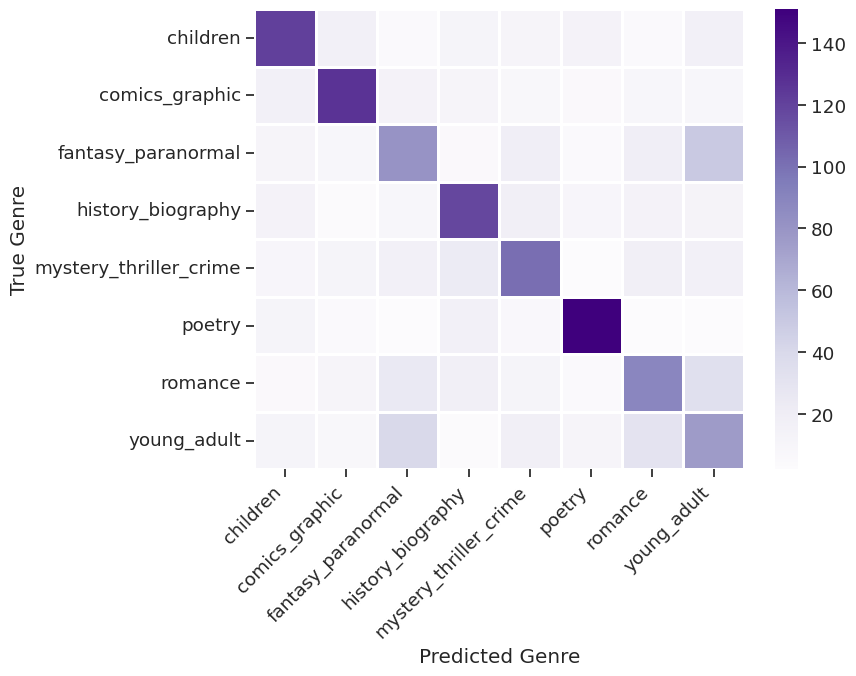

In [50]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct labels for each genre.

Now, let's remove the diagonal from the plot to highlight the misclassifications.

In [51]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

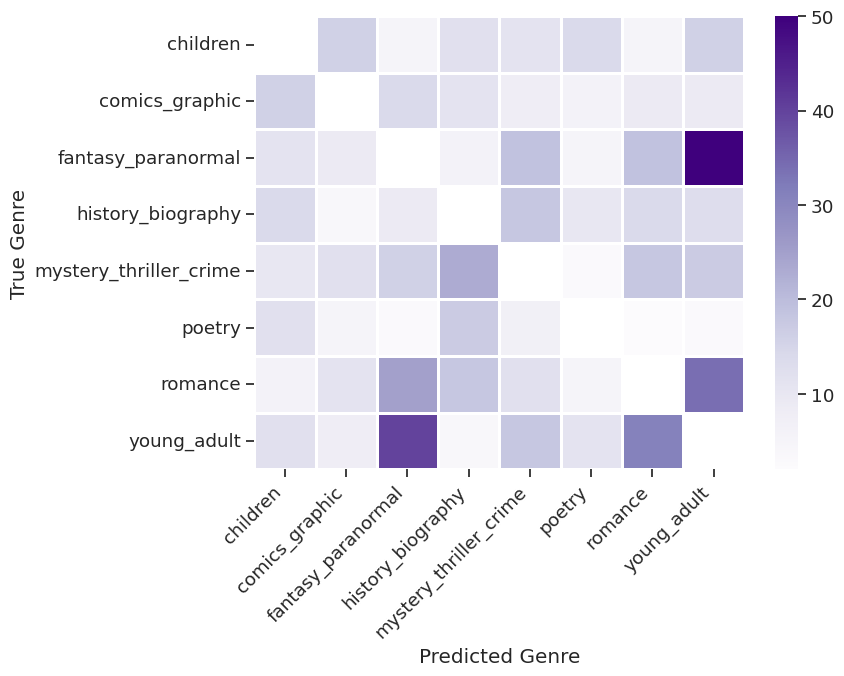

In [52]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There's much more you can do with your own dataset and labels! Classification can be used to apply a small set of labels across a big dataset; to explore misclassifications to better understand users; and much more! We hope you'll use this tutorial in all kinds of creative ways.